In [1]:
from load_mnist import *
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import datetime

In [2]:
def plot_images(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Load traditional MNIST dataset
This dataset is taken from http://yann.lecun.com/exdb/mnist/

In [3]:
images_tr, labels_tr = load_mnist('MNIST/')
images_tst, labels_tst = load_mnist('MNIST/', 't10k')

X_tr, y_tr = images_tr, labels_tr
X_tst, y_tst = images_tst, labels_tst

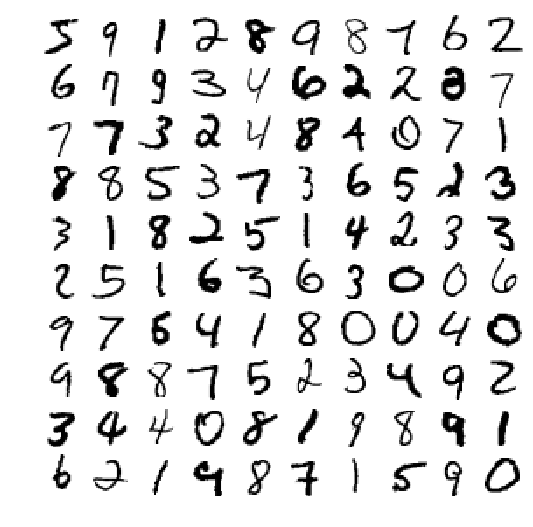

In [4]:
# show some images
plt.figure(figsize=(9,9))
example_images = np.r_[X_tr[:12000:600], X_tr[13000:30600:600], X_tr[30600:60000:590]]
plot_images(example_images, images_per_row=10)
# save_fig("more_images_plot")
plt.show()

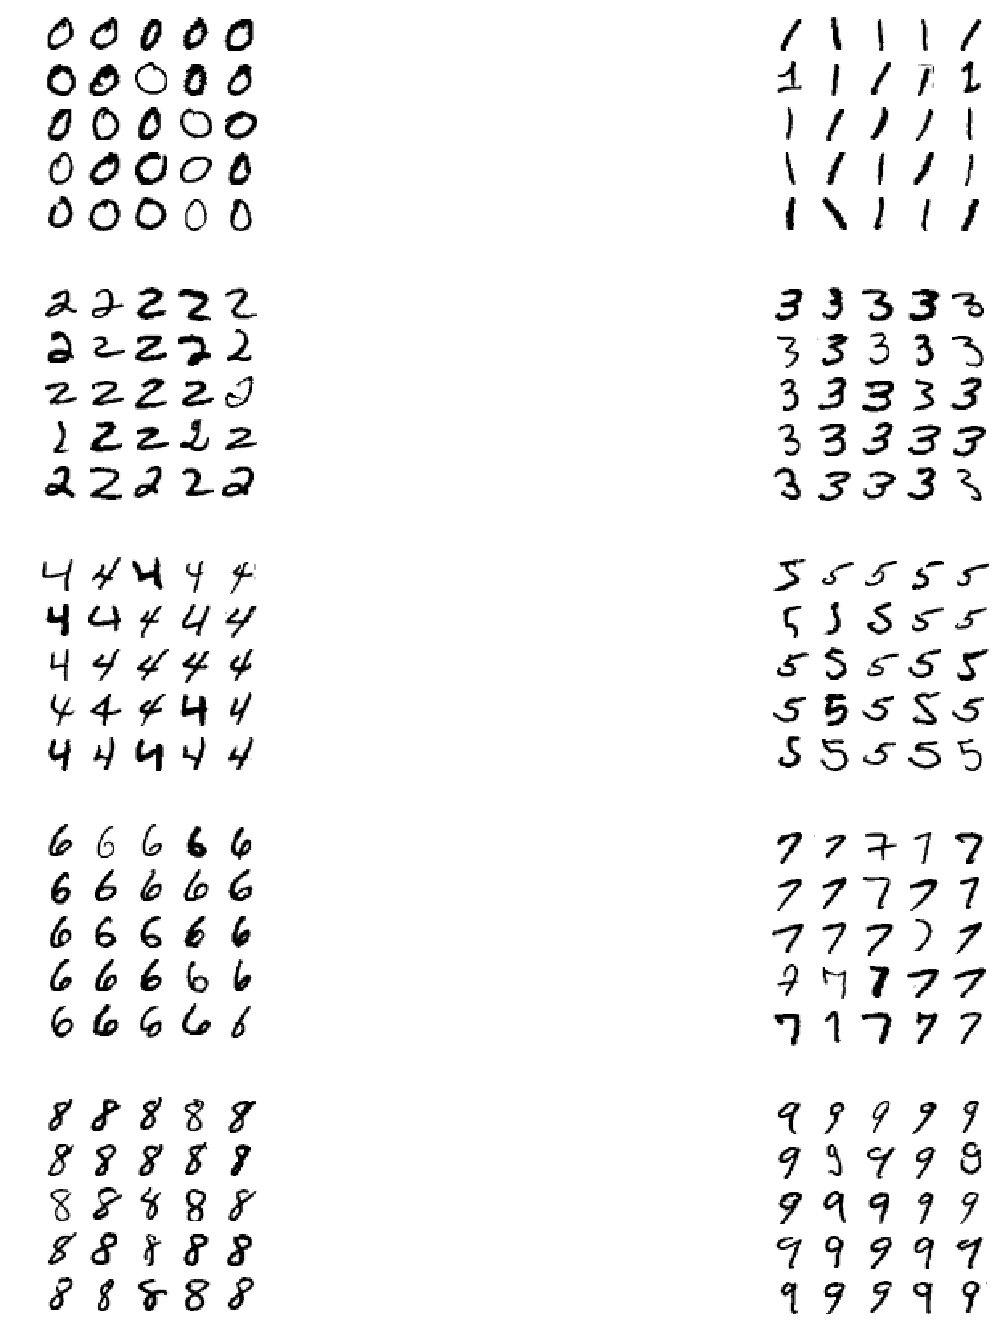

In [5]:
# plot images for each label
X_0 = X_tr[(y_tr == 0)]
X_1 = X_tr[(y_tr == 1)]
X_2 = X_tr[(y_tr == 2)]
X_3 = X_tr[(y_tr == 3)]
X_4 = X_tr[(y_tr == 4)]
X_5 = X_tr[(y_tr == 5)]
X_6 = X_tr[(y_tr == 6)]
X_7 = X_tr[(y_tr == 7)]
X_8 = X_tr[(y_tr == 8)]
X_9 = X_tr[(y_tr == 9)]

plt.figure(figsize=(24,24))
plt.subplot(521); plot_images(X_0[:25], images_per_row=5)
plt.subplot(522); plot_images(X_1[:25], images_per_row=5)
plt.subplot(523); plot_images(X_2[:25], images_per_row=5)
plt.subplot(524); plot_images(X_3[:25], images_per_row=5)
plt.subplot(525); plot_images(X_4[:25], images_per_row=5)
plt.subplot(526); plot_images(X_5[:25], images_per_row=5)
plt.subplot(527); plot_images(X_6[:25], images_per_row=5)
plt.subplot(528); plot_images(X_7[:25], images_per_row=5)
plt.subplot(529); plot_images(X_8[:25], images_per_row=5)
plt.subplot(5,2,10); plot_images(X_9[:25], images_per_row=5)
# save_fig("images_for_each_label")
plt.show()

## Scaler

Rescale the values of the image data into the interval [0.01, 0.99] by dividing (255 * 0.98 + 0.01), which put values between 0 and 1 but not including 0 and 1.

In [6]:
X_tr = X_tr / 255 * 0.98 + 0.01
X_tst = X_tst / 255 * 0.98 + 0.01

## Binary Classifier

Choose 5 and 6

In [7]:
#Select 5 & 6 from training and test
train_filter = np.where((y_tr == 5 ) | (y_tr == 6))
test_filter = np.where((y_tst == 5) | (y_tst == 6))
X_tr_b, y_tr_b = X_tr[train_filter], y_tr[train_filter]
X_tst_b, y_tst_b = X_tst[test_filter], y_tst[test_filter]

#Convert to 0 and 1
y_tr_binary = (y_tr_b == 5).astype(np.float)
y_tst_binary = (y_tst_b == 5).astype(np.float)

y_tr_binary_expand = np.expand_dims(y_tr_binary, axis=1)
y_tst_binary_expand = np.expand_dims(y_tst_binary, axis=1)

In [8]:
def sigmoid(t):
    return np.exp(t) / (1 + np.exp(t))

In [9]:
def calculate_loss(y, tx, w):
    p = sigmoid(tx.dot(w))
    loss = np.sum(-y * np.log(p) - (1 - y) * np.log(1 - p)) / y.shape[0]
    return loss

In [10]:
def calculate_gradient(y, tx, w):
    p = sigmoid(tx.dot(w))
    gradient = np.dot(tx.T, (p - y)) / y.shape[0]
    return gradient

In [11]:
def learning_by_gradient_descent(y, tx, w, tau):
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    w -= tau * gradient
    return loss, w

In [12]:
def predict_probs(tx, w):
    return sigmoid(tx.dot(w))

In [13]:
def predict(tx, w, threshold=0.5):
    return predict_probs(tx, w) >= threshold

In [14]:
def logistic_regression_gradient_descent_demo(y, x, max_iter, tau):
    # init parameters
    max_iter = max_iter
    threshold = 1e-8
    tau = tau #change to see the diff
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # Start GD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, tau)
        prediction = predict(tx, w, threshold=0.5).astype(np.float)
#         print(prediction)
        accuracy = (prediction == y).mean()
        tprediction = predict(np.c_[np.ones((y_tst_b.shape[0], 1)), X_tst_b], w, threshold=0.5).astype(np.float)
        taccuracy = (tprediction == y_tst_binary_expand).mean()
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    # Print result
    print("Binary GD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(y, tx, w)))
    
    # return for confusion matrix
    y_pred = prediction.flatten()
    y_act = y.flatten()
    return y_pred, y_act

Current iteration=0, loss=0.6931471805599453, training accuracy=0.7779345621306993, test accuracy=0.7962162162162162
Current iteration=100, loss=0.06224963016081031, training accuracy=0.9783049651644766, test accuracy=0.98
Current iteration=200, loss=0.054614441526152024, training accuracy=0.9818326131052121, test accuracy=0.98
Current iteration=300, loss=0.05060248717411059, training accuracy=0.9828027162889144, test accuracy=0.9794594594594594
Current iteration=400, loss=0.047878820007835415, training accuracy=0.9834200546785431, test accuracy=0.9805405405405405
Current iteration=500, loss=0.04584923176985999, training accuracy=0.9842137754652086, test accuracy=0.981081081081081
Current iteration=600, loss=0.04425212963934622, training accuracy=0.9846547314578005, test accuracy=0.981081081081081
Current iteration=700, loss=0.0429476244324931, training accuracy=0.9851838786489109, test accuracy=0.9805405405405405
Current iteration=800, loss=0.04185262123014048, training accuracy=0.985

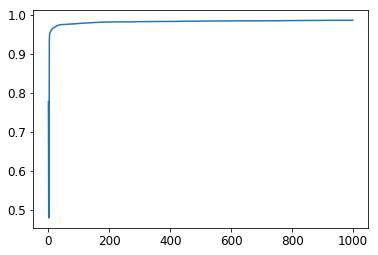

In [15]:
y_pred, y_act = logistic_regression_gradient_descent_demo(y_tr_binary_expand, X_tr_b, 1000, 1.4)

In [16]:
# Visualize the Confusion Matrix
# np.set_printoptions(suppress=True) # disable scientific numbers
y_act = pd.Series(y_act, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
conf_mat = pd.crosstab(y_act, y_pred)
# Normalized confusion matrix
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)
# print(df_confusion)
# sn.heatmap(conf_mat, annot=True)

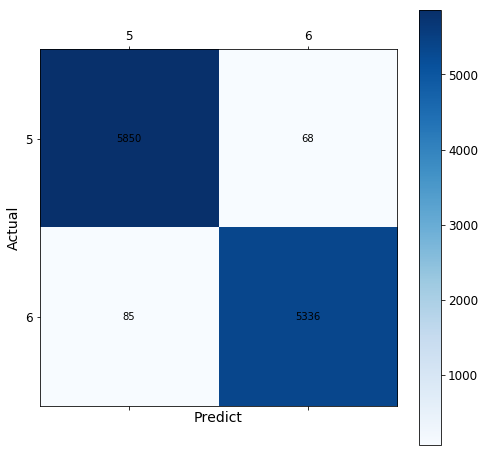

In [17]:
labels = ['5', '6']
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# plt.title('Binary Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')

for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0}'.format(z), ha='center', va='center') # for default in integer
#     ax.text(j, i, '{:0.2%}'.format(z), ha='center', va='center') # for normalized in percentage
    
plt.show()

## Newton's method

In [18]:
def calculate_loss(y, tx, w):
    p = sigmoid(tx.dot(w))
    loss = np.sum(-y * np.log(p) - (1 - y) * np.log(1 - p)) / y.shape[0]
    return loss

In [19]:
def predict(tx, w, threshold=0.5):
    return predict_probs(tx, w) >= threshold

In [20]:
def calculate_hessian(y, tx, w, alpha):
    p = sigmoid(tx.dot(w))
    diag = np.diag((p * (1 - p)).flatten())
    hessian = tx.T.dot(diag).dot(tx) / y.shape[0] + alpha * np.identity(w.shape[0])
    return hessian

In [21]:
def logistic_regression(y, tx, w, alpha):
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w, alpha)
    return loss, gradient, hessian

In [22]:
def inv(m):
    a, b = m.shape
    if a != b:
        raise ValueError("Only square matrices are invertible.")
    i = np.eye(a,a)
    return np.linalg.lstsq(m, i, rcond=None)[0]

In [23]:
def learning_by_newton_method(y, tx, w, alpha):
    loss, gradient, hessian = logistic_regression(y, tx, w, alpha)
    loss += (alpha/2) * np.sum(w*w)
    gradient += alpha*w
    w -= np.linalg.solve(hessian, gradient)
    #w -= np.dot(inv(hessian), gradient)
    return loss, w

In [24]:
def logistic_regression_newton_method_demo(y, x):
    # init parameters
    max_iter = 100
    threshold = 1e-8
    tau = 1e-7
    alpha = 0.01
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # Start Newton's
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, alpha)
        # log info
        prediction = predict(tx, w, threshold=0.5).astype(np.float)
        accuracy = (prediction == y).mean()
        tprediction = predict(np.c_[np.ones((y_tst_b.shape[0], 1)), X_tst_b], w, threshold=0.5).astype(np.int)
        taccuracy = (tprediction == y_tst_binary_expand).mean()
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        losses.append(loss)
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break

    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("Newton's: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)

Current iteration=0, the loss=0.6931471805599453, training accuracy=0.9762765675985536, test accuracy=0.9740540540540541
Current iteration=1, the loss=0.2237744662767003, training accuracy=0.9774230531792927, test accuracy=0.98
Current iteration=2, the loss=0.14157725853830772, training accuracy=0.9772466707822559, test accuracy=0.98
Current iteration=3, the loss=0.11568765590253416, training accuracy=0.9773348619807743, test accuracy=0.9794594594594594
Current iteration=4, the loss=0.11057302510841538, training accuracy=0.9770702883852191, test accuracy=0.9794594594594594
Current iteration=5, the loss=0.11028298898662427, training accuracy=0.9769820971867008, test accuracy=0.9794594594594594
Current iteration=6, the loss=0.1102817616010881, training accuracy=0.9769820971867008, test accuracy=0.9794594594594594
Current iteration=7, the loss=0.11028176157531625, training accuracy=0.9769820971867008, test accuracy=0.9794594594594594
Newton's: execution time=26.312 seconds


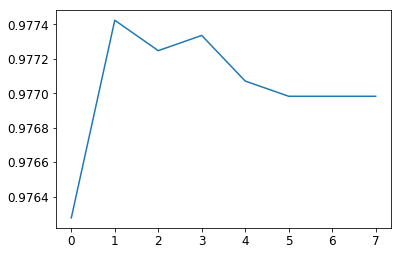

In [25]:
logistic_regression_newton_method_demo(y_tr_binary_expand, X_tr_b)

## Stochastic Gradient Descent (Binary)

In [26]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [27]:
def stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha):
    """Stochastic gradient descent."""
    losses = []
    accuracies = []
    for n_iter in range(max_iter):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            gradient = calculate_gradient(y_batch, tx_batch, w)
            gradient += alpha*w
            # calculate loss
            loss = calculate_loss(y, tx, w)
            loss += (alpha/2) * np.sum(w*w)
            # update w through the stochastic gradient update
            w -= tau * gradient
            
            prediction = predict(tx, w, threshold=0.5).astype(np.float)
            accuracy = (prediction == y).mean()
            tprediction = predict(np.c_[np.ones((y_tst_b.shape[0], 1)), X_tst_b], w, threshold=0.5).astype(np.float)
            taccuracy = (tprediction == y_tst_binary_expand).mean()
            losses.append(loss)
            accuracies.append(accuracy)
        # visualization
        plt.plot(accuracies)
        print("SGD({bi}/{ti}): loss={l}, training accuracy={a}, test accuracy={ta}".format(
              bi=n_iter, ti=max_iter - 1, l=loss, a=accuracy, ta=taccuracy))
    return loss, w, accuracy, prediction

In [28]:
def logistic_regression_stochastic_gradient_descent_demo(y, x, max_iter, tau):
    # init parameters
    max_iter = max_iter
    threshold = 1e-8
    tau = tau #change to see the diff
    alpha = 1e-7
    batch_size = 1

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # Start SGD
    start_time = datetime.datetime.now()
    # start the logistic regression
    # get loss and update w.
    loss, w, accuracy, prediction = stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha)
    #taccuracy = getAccuracy(X_tst, y_tst, w)
    # log info
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    # Print result
    print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

    
    # return for confusion matrix
    y_pred = prediction.flatten()
    y_act = y.flatten()
    return y_pred, y_act

SGD(0/999): loss=0.6931471805599453, training accuracy=0.47808448716818064, test accuracy=0.4821621621621622
SGD(1/999): loss=1.076564082420242, training accuracy=0.5227974248170033, test accuracy=0.518918918918919
SGD(2/999): loss=1.1323356707432468, training accuracy=0.5220037040303378, test accuracy=0.5178378378378379
SGD(3/999): loss=1.2991160695805346, training accuracy=0.5220037040303378, test accuracy=0.5178378378378379
SGD(4/999): loss=1.3304839154844947, training accuracy=0.7382485227974248, test accuracy=0.7497297297297297
SGD(5/999): loss=0.502158974545904, training accuracy=0.728282917364847, test accuracy=0.7486486486486487
SGD(6/999): loss=0.5357252152038924, training accuracy=0.6786312725989946, test accuracy=0.6956756756756757
SGD(7/999): loss=0.587895544180607, training accuracy=0.519534350471823, test accuracy=0.5378378378378378
SGD(8/999): loss=0.9062692498187193, training accuracy=0.4998677132022224, test accuracy=0.5113513513513513
SGD(9/999): loss=1.00588113480096

SGD(78/999): loss=0.3478095204316859, training accuracy=0.841520416262457, test accuracy=0.8508108108108108
SGD(79/999): loss=0.3618105030510195, training accuracy=0.9316518211482494, test accuracy=0.9324324324324325
SGD(80/999): loss=0.19500023361914773, training accuracy=0.9313872475526942, test accuracy=0.9324324324324325
SGD(81/999): loss=0.19527528373852843, training accuracy=0.933856601111209, test accuracy=0.9318918918918919
SGD(82/999): loss=0.1903104030996081, training accuracy=0.9339447923097275, test accuracy=0.9318918918918919
SGD(83/999): loss=0.19038062095761113, training accuracy=0.9357968074786136, test accuracy=0.9335135135135135
SGD(84/999): loss=0.18390680422976124, training accuracy=0.9320927771408414, test accuracy=0.9324324324324325
SGD(85/999): loss=0.19468930714229535, training accuracy=0.9440867801393421, test accuracy=0.9410810810810811
SGD(86/999): loss=0.16207764625939247, training accuracy=0.9457624129111915, test accuracy=0.9448648648648649
SGD(87/999): lo

SGD(153/999): loss=0.15513275697254436, training accuracy=0.9383543522356469, test accuracy=0.9372972972972973
SGD(154/999): loss=0.15525068558264515, training accuracy=0.9383543522356469, test accuracy=0.9372972972972973
SGD(155/999): loss=0.15526647590416898, training accuracy=0.9383543522356469, test accuracy=0.9372972972972973
SGD(156/999): loss=0.15535528387348635, training accuracy=0.93271011553047, test accuracy=0.9324324324324325
SGD(157/999): loss=0.17078178856151918, training accuracy=0.9141899638416086, test accuracy=0.9248648648648649
SGD(158/999): loss=0.22068829888597735, training accuracy=0.9141899638416086, test accuracy=0.9248648648648649
SGD(159/999): loss=0.22074916356437183, training accuracy=0.9210688773260428, test accuracy=0.9275675675675675
SGD(160/999): loss=0.20222341217220277, training accuracy=0.9199223917453038, test accuracy=0.927027027027027
SGD(161/999): loss=0.20592451494962616, training accuracy=0.9193932445541935, test accuracy=0.927027027027027
SGD(1

SGD(230/999): loss=0.11093184210713089, training accuracy=0.9593438574830232, test accuracy=0.9572972972972973
SGD(231/999): loss=0.11089798250637803, training accuracy=0.95952023988006, test accuracy=0.9578378378378378
SGD(232/999): loss=0.11085550589174606, training accuracy=0.959079283887468, test accuracy=0.9583783783783784
SGD(233/999): loss=0.11113721076794086, training accuracy=0.959079283887468, test accuracy=0.9583783783783784
SGD(234/999): loss=0.11113720982332068, training accuracy=0.9596966222770967, test accuracy=0.9583783783783784
SGD(235/999): loss=0.1102732553028636, training accuracy=0.95952023988006, test accuracy=0.9589189189189189
SGD(236/999): loss=0.1102698744317491, training accuracy=0.9589910926889497, test accuracy=0.9578378378378378
SGD(237/999): loss=0.11011016212099681, training accuracy=0.9589910926889497, test accuracy=0.9578378378378378
SGD(238/999): loss=0.11013803881084566, training accuracy=0.9589910926889497, test accuracy=0.9572972972972973
SGD(239/9

SGD(306/999): loss=0.10425805999967876, training accuracy=0.8771496604638856, test accuracy=0.8924324324324324
SGD(307/999): loss=0.30769238935154053, training accuracy=0.8771496604638856, test accuracy=0.8924324324324324
SGD(308/999): loss=0.30769263774295447, training accuracy=0.9430284857571214, test accuracy=0.9464864864864865
SGD(309/999): loss=0.14531346656888416, training accuracy=0.9430284857571214, test accuracy=0.9464864864864865
SGD(310/999): loss=0.14531515978038376, training accuracy=0.9392362642208307, test accuracy=0.9432432432432433
SGD(311/999): loss=0.15481795554022051, training accuracy=0.9391480730223124, test accuracy=0.9432432432432433
SGD(312/999): loss=0.15531817583211616, training accuracy=0.9391480730223124, test accuracy=0.9432432432432433
SGD(313/999): loss=0.15453971842533215, training accuracy=0.9462033689037834, test accuracy=0.9497297297297297
SGD(314/999): loss=0.13739670599183115, training accuracy=0.9462033689037834, test accuracy=0.9497297297297297
S

SGD(381/999): loss=0.08967950499805406, training accuracy=0.9699268013052298, test accuracy=0.9702702702702702
SGD(382/999): loss=0.08990011575459124, training accuracy=0.9699268013052298, test accuracy=0.9702702702702702
SGD(383/999): loss=0.08989461653378616, training accuracy=0.9699268013052298, test accuracy=0.9702702702702702
SGD(384/999): loss=0.08987990936272094, training accuracy=0.9700149925037481, test accuracy=0.9702702702702702
SGD(385/999): loss=0.0897658560836349, training accuracy=0.9700149925037481, test accuracy=0.9702702702702702
SGD(386/999): loss=0.08974466033425432, training accuracy=0.9699268013052298, test accuracy=0.9702702702702702
SGD(387/999): loss=0.08971810514018543, training accuracy=0.966575535761531, test accuracy=0.9681081081081081
SGD(388/999): loss=0.09352503456922437, training accuracy=0.9666637269600494, test accuracy=0.9686486486486486
SGD(389/999): loss=0.09320781022556371, training accuracy=0.9676338301437517, test accuracy=0.9686486486486486
SGD

SGD(456/999): loss=0.10028046611384175, training accuracy=0.9671928741511597, test accuracy=0.9686486486486486
SGD(457/999): loss=0.10036065598401918, training accuracy=0.9671928741511597, test accuracy=0.9686486486486486
SGD(458/999): loss=0.10057252286268244, training accuracy=0.9671928741511597, test accuracy=0.9686486486486486
SGD(459/999): loss=0.10057263690893577, training accuracy=0.9671928741511597, test accuracy=0.9686486486486486
SGD(460/999): loss=0.1008777512854677, training accuracy=0.9671928741511597, test accuracy=0.9686486486486486
SGD(461/999): loss=0.10087966307359687, training accuracy=0.9671046829526413, test accuracy=0.9686486486486486
SGD(462/999): loss=0.10088763571426597, training accuracy=0.9676338301437517, test accuracy=0.9681081081081081
SGD(463/999): loss=0.09556717945952443, training accuracy=0.9676338301437517, test accuracy=0.9681081081081081
SGD(464/999): loss=0.09556921280605171, training accuracy=0.9676338301437517, test accuracy=0.9681081081081081
SG

SGD(531/999): loss=0.09824604394113667, training accuracy=0.9664873445630127, test accuracy=0.9632432432432433
SGD(532/999): loss=0.09586878045516066, training accuracy=0.9664873445630127, test accuracy=0.9632432432432433
SGD(533/999): loss=0.09587923215870009, training accuracy=0.9664873445630127, test accuracy=0.9632432432432433
SGD(534/999): loss=0.09586490266104994, training accuracy=0.9671046829526413, test accuracy=0.9637837837837838
SGD(535/999): loss=0.0944453640172916, training accuracy=0.9671046829526413, test accuracy=0.9637837837837838
SGD(536/999): loss=0.09445762604559388, training accuracy=0.9679865949378252, test accuracy=0.9654054054054054
SGD(537/999): loss=0.09205368150134283, training accuracy=0.9679865949378252, test accuracy=0.9654054054054054
SGD(538/999): loss=0.09205379385752029, training accuracy=0.9679865949378252, test accuracy=0.9654054054054054
SGD(539/999): loss=0.092038595709479, training accuracy=0.9471734720874857, test accuracy=0.9454054054054054
SGD(

SGD(610/999): loss=0.09554600143637616, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(611/999): loss=0.09568279562883963, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(612/999): loss=0.09561972124069007, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(613/999): loss=0.09562472831180245, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(614/999): loss=0.09574361882554643, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(615/999): loss=0.09574680941984354, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(616/999): loss=0.09574686853033157, training accuracy=0.9662227709674575, test accuracy=0.9621621621621622
SGD(617/999): loss=0.0957464785972996, training accuracy=0.967016491754123, test accuracy=0.9627027027027028
SGD(618/999): loss=0.09475396544199556, training accuracy=0.9669283005556045, test accuracy=0.9627027027027028
SGD

SGD(691/999): loss=0.09028073349479358, training accuracy=0.9685157421289355, test accuracy=0.967027027027027
SGD(692/999): loss=0.09015458448608706, training accuracy=0.9683393597318988, test accuracy=0.9664864864864865
SGD(693/999): loss=0.09081122951146381, training accuracy=0.9682511685333803, test accuracy=0.9664864864864865
SGD(694/999): loss=0.09066505041136264, training accuracy=0.9687803157244907, test accuracy=0.9675675675675676
SGD(695/999): loss=0.08999457473279483, training accuracy=0.9687803157244907, test accuracy=0.9675675675675676
SGD(696/999): loss=0.09002032368260998, training accuracy=0.9686921245259723, test accuracy=0.9675675675675676
SGD(697/999): loss=0.08988785929995066, training accuracy=0.9686921245259723, test accuracy=0.9675675675675676
SGD(698/999): loss=0.08988624048918659, training accuracy=0.9687803157244907, test accuracy=0.9675675675675676
SGD(699/999): loss=0.08987996114477471, training accuracy=0.9694858453126378, test accuracy=0.9681081081081081
SG

SGD(769/999): loss=0.09579102583169335, training accuracy=0.9669283005556045, test accuracy=0.9654054054054054
SGD(770/999): loss=0.09580020981996548, training accuracy=0.9668401093570862, test accuracy=0.9654054054054054
SGD(771/999): loss=0.09591981960249688, training accuracy=0.9668401093570862, test accuracy=0.9654054054054054
SGD(772/999): loss=0.09592250535402964, training accuracy=0.9668401093570862, test accuracy=0.9654054054054054
SGD(773/999): loss=0.09592276428297578, training accuracy=0.9669283005556045, test accuracy=0.9654054054054054
SGD(774/999): loss=0.0958672001778098, training accuracy=0.9672810653496781, test accuracy=0.9654054054054054
SGD(775/999): loss=0.09507086997120236, training accuracy=0.9672810653496781, test accuracy=0.9654054054054054
SGD(776/999): loss=0.09507095388099342, training accuracy=0.9672810653496781, test accuracy=0.9654054054054054
SGD(777/999): loss=0.09507095365871991, training accuracy=0.9672810653496781, test accuracy=0.9654054054054054
SG

SGD(846/999): loss=0.11145254324494731, training accuracy=0.9631360790193139, test accuracy=0.9616216216216216
SGD(847/999): loss=0.11114245268847826, training accuracy=0.9631360790193139, test accuracy=0.9616216216216216
SGD(848/999): loss=0.11114258287264556, training accuracy=0.9631360790193139, test accuracy=0.9616216216216216
SGD(849/999): loss=0.11114414108042332, training accuracy=0.9633124614163506, test accuracy=0.9605405405405405
SGD(850/999): loss=0.1111571664008511, training accuracy=0.9633124614163506, test accuracy=0.9605405405405405
SGD(851/999): loss=0.11115781044785805, training accuracy=0.9566099303289531, test accuracy=0.9535135135135135
SGD(852/999): loss=0.12910860749678693, training accuracy=0.9572272687185819, test accuracy=0.9540540540540541
SGD(853/999): loss=0.12780008053816963, training accuracy=0.9572272687185819, test accuracy=0.9540540540540541
SGD(854/999): loss=0.12780107732911497, training accuracy=0.9572272687185819, test accuracy=0.9540540540540541
SG

SGD(922/999): loss=0.0935716043122715, training accuracy=0.9688685069230091, test accuracy=0.9654054054054054
SGD(923/999): loss=0.09272130673152931, training accuracy=0.9688685069230091, test accuracy=0.9654054054054054
SGD(924/999): loss=0.09271865195945539, training accuracy=0.9688685069230091, test accuracy=0.9654054054054054
SGD(925/999): loss=0.09271860813904843, training accuracy=0.9688685069230091, test accuracy=0.9654054054054054
SGD(926/999): loss=0.092724562663393, training accuracy=0.9688685069230091, test accuracy=0.9654054054054054
SGD(927/999): loss=0.09272435811047836, training accuracy=0.9692212717170826, test accuracy=0.965945945945946
SGD(928/999): loss=0.09271366901679878, training accuracy=0.969309462915601, test accuracy=0.967027027027027
SGD(929/999): loss=0.09228208106859168, training accuracy=0.9664873445630127, test accuracy=0.9654054054054054
SGD(930/999): loss=0.10136578529723778, training accuracy=0.9662227709674575, test accuracy=0.9654054054054054
SGD(931

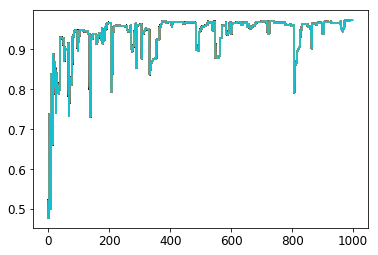

In [29]:
y_pred, y_act = logistic_regression_stochastic_gradient_descent_demo(y_tr_binary_expand, X_tr_b, 1000, 0.1)

In [30]:
# Visualize the Confusion Matrix
# np.set_printoptions(suppress=True) # disable scientific numbers
y_act = pd.Series(y_act, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
conf_mat = pd.crosstab(y_act, y_pred)
# Normalized confusion matrix
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)
# print(df_confusion)
# sn.heatmap(conf_mat, annot=True)

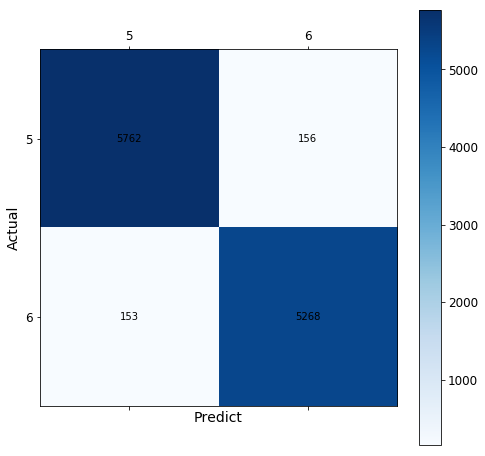

In [31]:
labels = ['5', '6']
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# plt.title('Binary Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')

for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0}'.format(z), ha='center', va='center') # for default in integer
#     ax.text(j, i, '{:0.2%}'.format(z), ha='center', va='center') # for normalized in percentage
    
plt.show()

## Softmax

In [32]:
def onehotencoding(y):
    return (np.arange(np.max(y) + 1) == y[:, None]).astype(np.float)

In [33]:
def softmax(z):
    z -= np.max(z)
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [34]:
def calculate_loss(y, tx, w):
    softm = softmax(tx.dot(w))
    loss = - np.sum(y * np.log(softm)) / y.shape[0]
    prediction = np.argmax(softm, axis=1)
    return softm, loss, prediction

In [35]:
def calculate_gradient(y, tx, w):
    softm = softmax(tx.dot(w))
    return - np.dot(tx.T, (y - softm)) / y.shape[0]

In [36]:
def learning_by_gradient_descent(y, tx, w, tau, alpha):
    y_enc = onehotencoding(y)
    softm, loss, prediction = calculate_loss(y_enc, tx, w)
    loss += (alpha/2) * np.sum(w*w)
    gradient = calculate_gradient(y_enc, tx, w)
    gradient += alpha
    w -= tau * gradient
    accuracy = np.sum(prediction == y)/ y.shape[0]
    return loss, w, accuracy, prediction

In [37]:
def getAccuracy(x, y, w):
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    softm = softmax(tx.dot(w))
    prediction = np.argmax(softm, axis=1)
    accuracy = np.sum(prediction == y)/ y.shape[0]
    return accuracy

In [38]:
def logistic_regression_gradient_descent_demo(y, x, max_iter, tau):
    # init parameters
    max_iter = max_iter
    threshold = 1e-8
    tau = tau #change to see the diff
    alpha = 1e-6
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))
    
    # Start GD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w, accuracy, prediction = learning_by_gradient_descent(y, tx, w, tau, alpha)
        taccuracy = getAccuracy(X_tst, y_tst, w)
        tprediction = np.argmax(softmax(np.c_[np.ones((y_tst.shape[0], 1)), X_tst].dot(w)), axis=1)
        # log info
        if iter % 50 == 0:
            print("Current iteration={i}, loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        losses.append(loss)
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(onehotencoding(y), tx, w)))
    # return for confusion matrix
    y_pred = prediction.flatten()
    y_act = y.flatten()
    return y_pred, y_act

Current iteration=0, loss=2.3025850929940437, training accuracy=0.09871666666666666, test accuracy=0.6729
Current iteration=50, loss=0.42567777421179687, training accuracy=0.8878333333333334, test accuracy=0.8955
Current iteration=100, loss=0.3705240902937621, training accuracy=0.8991666666666667, test accuracy=0.9063
Current iteration=150, loss=0.3460395206289189, training accuracy=0.9045666666666666, test accuracy=0.9099
Current iteration=200, loss=0.3313268187666627, training accuracy=0.9085166666666666, test accuracy=0.9141
Current iteration=250, loss=0.3212032853123426, training accuracy=0.9109666666666667, test accuracy=0.9158
Current iteration=300, loss=0.31367429220200344, training accuracy=0.91315, test accuracy=0.9171
Current iteration=350, loss=0.3077830893212166, training accuracy=0.9149666666666667, test accuracy=0.918
Current iteration=400, loss=0.30300441881364976, training accuracy=0.9162833333333333, test accuracy=0.9188
Current iteration=450, loss=0.2990222723326651, 

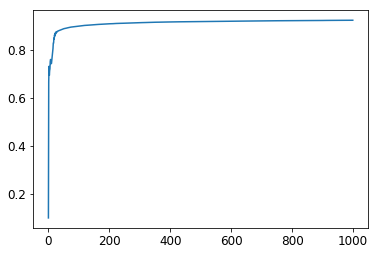

In [39]:
y_pred, y_act = logistic_regression_gradient_descent_demo(y_tr, X_tr, 1000, 0.7)

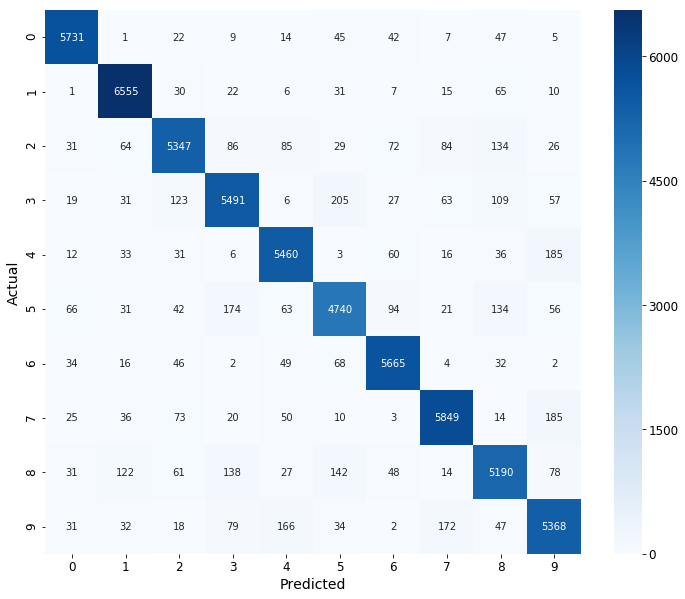

In [42]:
# Visualize the Confusion Matrix
# np.set_printoptions(suppress=True) # disable scientific numbers
y_act = pd.Series(y_act, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
conf_mat = pd.crosstab(y_act, y_pred)
plt.figure(figsize=(12, 10))
# print(conf_mat)
# Normalized confusion matrix
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)
# print(conf_mat_norm)
import seaborn as sn
sn.heatmap(conf_mat, cmap="Blues",annot=True, fmt='g')

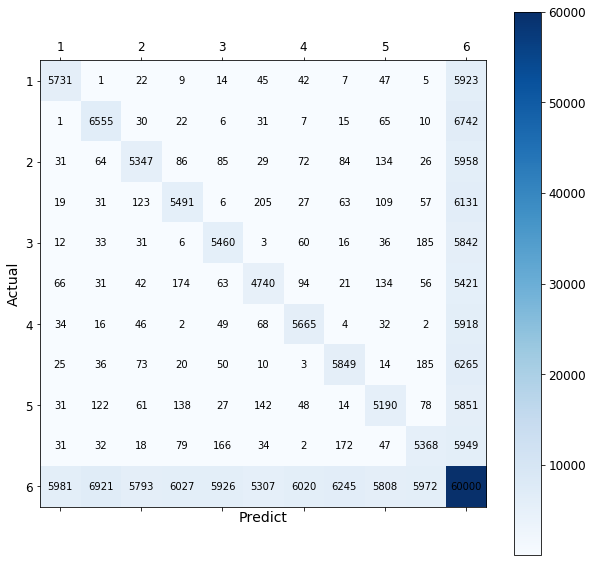

In [41]:
labels = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
# plt.title('Binary Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')

for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0}'.format(z), ha='center', va='center') # for default in integer
#     ax.text(j, i, '{:0.2%}'.format(z), ha='center', va='center') # for normalized in percentage
    
plt.show()

## Stochastic Gradient Descent (Multiclass)

In [ ]:
def stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha):
    """Stochastic gradient descent."""
    losses = []
    accuracies = []
    y_enc = onehotencoding(y)
    for n_iter in range(max_iter):
        for y_batch, tx_batch in batch_iter(y_enc, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            gradient = calculate_gradient(y_batch, tx_batch, w)
            gradient += alpha*w
            # calculate loss
            softm, loss, prediction = calculate_loss(y_enc, tx, w)
            loss += (alpha/2) * np.sum(w*w)
            # update w through the stochastic gradient update
            w -= tau * gradient
            accuracy = np.sum(prediction == y)/ y.shape[0]
            taccuracy = getAccuracy(X_tst, y_tst, w)
            losses.append(loss)
            accuracies.append(accuracy)
        print("SGD({bi}/{ti}): loss={l}, training accuracy={a}, test accuracy={ta}".format(
              bi=n_iter, ti=max_iter - 1, l=loss, a=accuracy, ta=taccuracy))
        # visualization
        plt.plot(accuracies)
    return loss, w, accuracy, prediction

In [ ]:
def logistic_regression_stochastic_gradient_descent_demo(y, x, max_iter, tau):
    # init parameters
    max_iter = max_iter
    threshold = 1e-8
    tau = tau #change to see the diff
    alpha = 1e-7
    batch_size = 1

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # Start SGD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    # get loss and update w.
    loss, w, accuracy, prediction = stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha)
    #taccuracy = getAccuracy(X_tst, y_tst, w)
    # log info
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    # Print result
    print("SGD: execution time={t:.3f} seconds".format(t=exection_time))
    
    # return for confusion matrix
    y_pred = prediction.flatten()
    y_act = y.flatten()
    return y_pred, y_act

In [ ]:
y_pred, y_act = logistic_regression_stochastic_gradient_descent_demo(y_tr, X_tr, 1000, 0.5)

# Load fashion MNIST dataset
This dataset is taken from https://github.com/zalandoresearch/fashion-mnist

In [ ]:
fashion_images_tr, fashion_labels_tr = load_mnist('FashionMNIST/')
fashion_images_tst, fashion_labels_tst = load_mnist('FashionMNIST/', 't10k')

X_tr, y_tr = fashion_images_tr, fashion_labels_tr
X_tst, y_tst = fashion_images_tst, fashion_labels_tst


In [ ]:
# show some images
plt.figure(figsize=(9,9))
example_images = np.r_[X_tr[:12000:600], X_tr[13000:30600:600], X_tr[30600:60000:590]]
plot_images(example_images, images_per_row=10)
# save_fig("more_images_plot")
plt.show()

In [ ]:
# plot images for each label
X_0 = X_tr[(y_tr == 0)]
X_1 = X_tr[(y_tr == 1)]
X_2 = X_tr[(y_tr == 2)]
X_3 = X_tr[(y_tr == 3)]
X_4 = X_tr[(y_tr == 4)]
X_5 = X_tr[(y_tr == 5)]
X_6 = X_tr[(y_tr == 6)]
X_7 = X_tr[(y_tr == 7)]
X_8 = X_tr[(y_tr == 8)]
X_9 = X_tr[(y_tr == 9)]

plt.figure(figsize=(24,24))
plt.subplot(521); plot_images(X_0[:25], images_per_row=5)
plt.subplot(522); plot_images(X_1[:25], images_per_row=5)
plt.subplot(523); plot_images(X_2[:25], images_per_row=5)
plt.subplot(524); plot_images(X_3[:25], images_per_row=5)
plt.subplot(525); plot_images(X_4[:25], images_per_row=5)
plt.subplot(526); plot_images(X_5[:25], images_per_row=5)
plt.subplot(527); plot_images(X_6[:25], images_per_row=5)
plt.subplot(528); plot_images(X_7[:25], images_per_row=5)
plt.subplot(529); plot_images(X_8[:25], images_per_row=5)
plt.subplot(5,2,10); plot_images(X_9[:25], images_per_row=5)
# save_fig("images_for_each_label")
plt.show()

print(X_0.shape)
print(X_1.shape)

## Softmax Regression

Compute your cost by negative log likelihood.

In [ ]:
def logistic_regression_penalized_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 1000
    threshold = 1e-8
    tau = 1e-6 #change to see the diff
    alpha = 1e-7
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # Start GD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w, accuracy = learning_by_gradient_descent(y, tx, w, tau, alpha)
        taccuracy = getAccuracy(X_tst, y_tst, w)
        # log info
        if iter % 10 == 0:
            print("Current iteration={i}, loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        losses.append(loss)
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(onehotencoding(y), tx, w)))

In [ ]:
logistic_regression_penalized_gradient_descent_demo(y_tr, X_tr)

## Stochastic Gradient Descent

In [ ]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [ ]:
def stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha):
    """Stochastic gradient descent."""
    losses = []
    accuracies = []
    y_enc = onehotencoding(y)
    for n_iter in range(max_iter):
        for y_batch, tx_batch in batch_iter(y_enc, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            gradient = calculate_gradient(y_batch, tx_batch, w)
            gradient += alpha*w
            # calculate loss
            softm, loss, prediction = calculate_loss(y_enc, tx, w)
            loss += (alpha/2) * np.sum(w*w)
            # update w through the stochastic gradient update
            w -= tau * gradient
            accuracy = np.sum(prediction == y)/ y.shape[0]
            taccuracy = getAccuracy(X_tst, y_tst, w)
            losses.append(loss)
        print("SGD({bi}/{ti}): loss={l}, training accuracy={a}, test accuracy={ta}".format(
              bi=n_iter, ti=max_iter - 1, l=loss, a=accuracy, ta=taccuracy))
    return loss, w, accuracy

In [ ]:
def logistic_regression_stochastic_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 1000
    threshold = 1e-8
    tau = 1e-6 #change to see the diff
    alpha = 1e-7
    batch_size = 1

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # Start SGD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    # get loss and update w.
    loss, w, accuracy = stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha)
    #taccuracy = getAccuracy(X_tst, y_tst, w)
    # log info
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("SGD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(onehotencoding(y), tx, w)))

In [ ]:
logistic_regression_stochastic_gradient_descent_demo(y_tr, X_tr)

In [ ]:
#softmax newton 
#grid search